# 10. 3D case

Until now we have exclusively processed 2D images, eventhough the sometimes came from 3D acquisition. We are now going to look at an example of 3D processing where we are going to use the same tools as in 2D but in a 3D version.

Extending an image processing pipeline from 2D to 3D can be challenging for two reasons: first, computations can become very slow because of the amount of data changes usually roughly by an order of magnitude, and second, visualization of both original and processed data is more complicated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.gray()
from ipywidgets import interact, IntSlider, fixed

import skimage.io as io
from skimage.transform import rescale, resize
from skimage.morphology import white_tophat
from skimage.feature import peak_local_max
from skimage.measure import regionprops, label
from skimage.filters import threshold_otsu, gaussian
import scipy.ndimage as ndi


#convenience functions
#create a segmentation image where background is NaN to use as overlay
def nan_image(image):
    image_nan = np.zeros(image.shape)
    image_nan[:] = np.nan
    for i in range(1,image.max()):
        image_nan[image==i]=i

#image plotting function used in concert with ipywidget interact. Plots a single image.
def plot_plane(t,im, cmap):
    
    plt.figure(figsize=(10,10))
    plt.imshow(im[t,:,:],cmap = cmap)
    plt.show()

#image plotting function used in concert with ipywidget interact. Plots two superposed images.
def plot_superpose(t, im1, im2, cmap):
    plt.figure(figsize=(10,10))
    plt.imshow(im1[t,:,:],cmap = 'gray')
    plt.imshow(im2[t,:,:],cmap = cmap, alpha = 0.3, vmin = 0, vmax = im2.max())
    plt.show()

#Wrapping function to create an interactive view of an image stack for one or a pair of stacks
def image_browser(image, image2 = None , color = True):
    if color == True:
        vals = np.linspace(0,1,int(image.max()))
        np.random.shuffle(vals)
        cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
    else:
        cmap = 'gray'
    
    if image2 is None:
        interact(plot_plane, t = IntSlider(min=0,max=image.shape[0],step=1,value=0,
                                           continuous_update = False),im = fixed(image), cmap = fixed(cmap));
    else:
        interact(plot_superpose, t = IntSlider(min=0,max=image.shape[0]-1,step=1,value=0,
                                               continuous_update = False),im1 = fixed(image), im2 = fixed(image2),cmap = fixed(cmap));
        

In [2]:
from skimage.morphology import binary_closing, white_tophat, label, watershed
from skimage.measure import regionprops, label
from skimage.feature import match_template, peak_local_max



We are going to look at a dataset of an embryo imaged in 3D in multiple wavelengths. We are first going to focus on one channel where the *nuclei* are marked. Then we will use that information to extract information from another channel where we will try to extract spot-like structures.

The goal here is to illustrate that most functions used before in 2D can be used in the same way in 3D, but with some new issues, especially around visualizations and computing time.

Let's load the first image and look at it along two projections:

In [3]:
image = io.imread('Data/BBBC032_v1_dataset/BMP4blastocystC3.tif')

In [4]:
image.shape

(172, 1344, 1024)

In [5]:
np.size(image)/10**6

236.716032

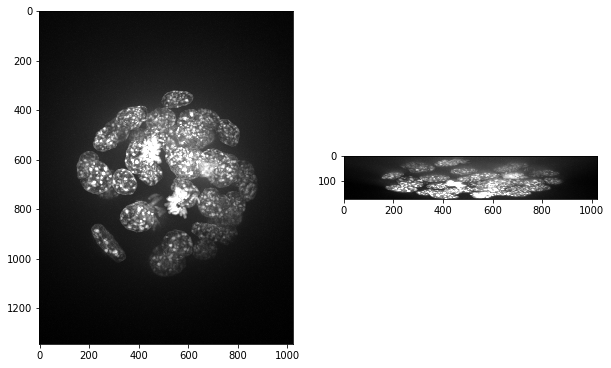

In [6]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(np.max(image,axis = 0))
ax[1].imshow(np.max(image,axis = 1));

The image is really large, so any operation we are going to do on it will be very slow (e.g. a filter will have to visit every single one of the 230 millions pixels). As we just want to identify the *nuclei* we don't care about the details in the image, so a practical thing to do is to resample the imge. As the z dimension is larger than the xy (image on the right looks squished) we are going to use the opportunity to "stretch" the image during resampling:

In [7]:
image_resampled = rescale(image,(0.5,0.15,0.15), multichannel=False,preserve_range=True, anti_aliasing=True)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [8]:
image_resampled.shape

(86, 202, 154)

Let's look at the result;

In [9]:
#image_resampled = gaussian(image_resampled,sigma=(2,2,2))

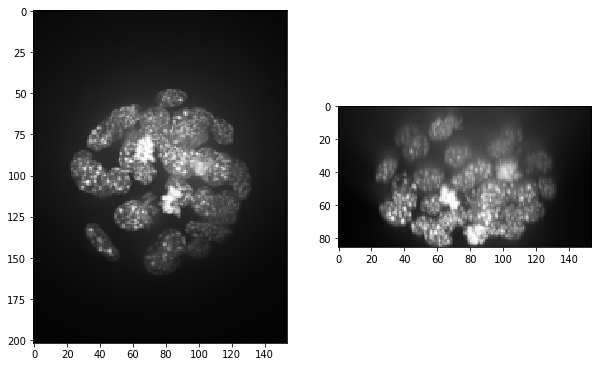

In [10]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(np.max(image_resampled,axis = 0))
ax[1].imshow(np.max(image_resampled,axis = 1));

To remove some of the glare in the image we can use a top-hat filter, which keeps objects which are smaller than a structuring element and brighter than their surroundings. "Flat" low-illumination regions get therefore removed: 

In [11]:
from skimage.morphology import binary_closing, white_tophat, label, watershed, black_tophat


In [12]:
im_tophat = white_tophat(image_resampled,selem=np.ones((20,20,20)))

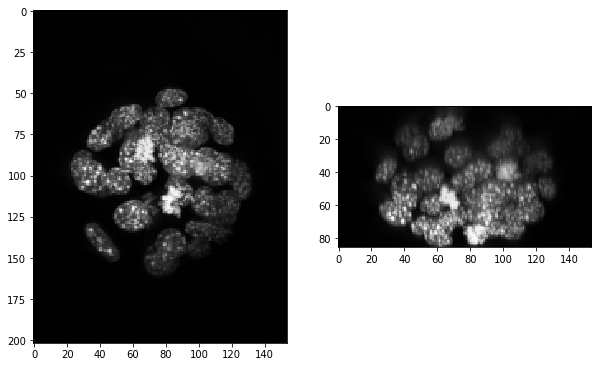

In [13]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(np.max(im_tophat,axis = 0))
ax[1].imshow(np.max(im_tophat,axis = 1));

We can have a look at what happens if we do a classical thresholding of the image, which works just like in 2D.

In [14]:
image_browser(im_tophat>threshold_otsu(im_tophat), color=False)

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=86), Output()), _dom_cl…

The result is poor because the *nucleus* signal is not homogeneous, *i.e.* each *nucleus* is made of sparse bright signals. To identify larger scale structures, we thus have to filter the image with a structuring element that has approximately the shape of the *nuclei*. A typical filter used to detect "blobs" is the LoG filter (Laplacian of a Gaussian).

The filter doesn't exist *per se* in scikit-image so we are going to use the one of scipy.

In [15]:
im_log = -ndi.filters.gaussian_laplace(im_tophat,(4,4,4))

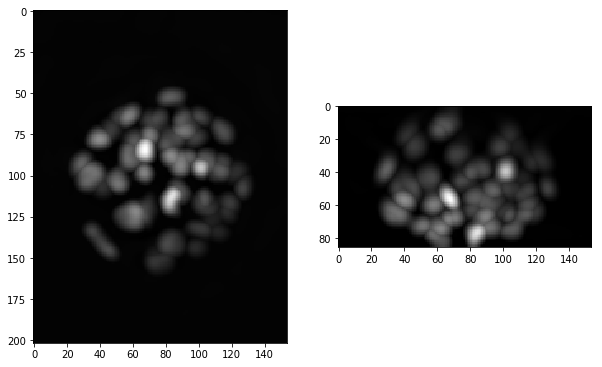

In [16]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(np.max(im_log,axis = 0), cmap = 'gray')
ax[1].imshow(np.max(im_log,axis = 1), cmap = 'gray')
plt.show()

Now that we have more homogeneous regions, we can try again to use a classical thresholding, which should give a much better result.

In [17]:
image_browser(im_log>threshold_otsu(im_log), color = False)

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=86), Output()), _dom_cl…

We can now go back to some of the methods we have seen previously: we can find local maxima corresponding to single *nuclei*, define a global mask, and use the watershed algorithm for segmentation.

In [18]:
peak_image = peak_local_max(im_log, footprint=np.ones((10,10,10)), indices=False, threshold_abs= 1)

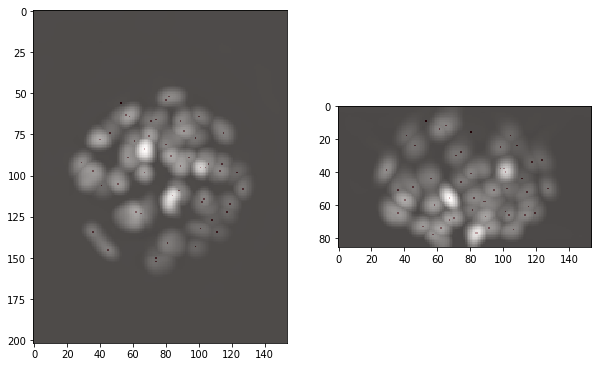

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(np.max(im_log,axis = 0), cmap = 'gray')
ax[0].imshow(np.max(peak_image,axis = 0), cmap = 'Reds',alpha = 0.3)

ax[1].imshow(np.max(im_log,axis = 1), cmap = 'gray')
ax[1].imshow(np.max(peak_image,axis = 1), cmap = 'Reds',alpha = 0.3)

plt.show()


In [ ]:
mask = im_log>threshold_otsu(im_log)
im_label = label(peak_image)
im_water = watershed(image=-im_log,markers=im_label,mask = mask, compactness=0.01)

In [ ]:
image_browser(im_log, im_water, color = False)

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=85), Output()), _dom_cl…

In [ ]:
image_browser(image_resampled, im_water, color = False)

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=85), Output()), _dom_cl…

The result is rather crude but a good start for potential further processing. Note that we didn't segment the *nuclei* *per se* but their convolution with a LoG filter. We can also visualize the result in 3D. For that we use the ipyvolume package which allows one to represent 3D data in various ways. For example as isosurface (on a binary image, it just gives the surface of the objects):

In [ ]:
import ipyvolume.pylab as ipv

In [ ]:
ipv.figure()
ipv.plot_isosurface(im_water>0)
ipv.show()

But we can of course also show the volume data of our resampled image:

In [ ]:
ipv.figure()
ipv.volshow(im_tophat.astype(int).T)
ipv.style.background_color('black')
ipv.show()

/usr/local/lib/python3.5/dist-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


## Detecting features within features

In [ ]:
image2 = io.imread('Data/BBBC032_v1_dataset/BMP4blastocystC1.tif')

In another wavelength, the collected signal appears as *puncti* in the image. We could for example now wish to know how many of those *puncti* appear in the *nuclei*. Here we cannot downscale the image as those small structures would otherwise disappear, so we use the fact that we know where nuclei are to just analyse those regions.

Let us first resize our segmentation map. Note that we use order = 0 (nearest neighbors) to preserve our labeling.

In [ ]:
im_nuclei_segm = resize(im_water, image.shape, order = 0, preserve_range=True)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [ ]:
np.unique(im_nuclei_segm)

Let's recover all the single *nuclei* regions using regionproperties

In [ ]:
regions = regionprops(im_nuclei_segm.astype(int), image2)

In [ ]:
im_crop = image2#regions[10].intensity_image

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(np.max(im_crop,axis = 0))
ax[1].imshow(np.max(im_crop,axis = 1))

The spots from those images have approximately a gaussian shape. So we can try to filter our image with an appropriately size 3D Gaussian to detect the spots:

In [ ]:
im_gauss = gaussian(im_crop, sigma = [1,1.5,1.5], preserve_range=True)

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(np.max(im_gauss,axis = 0))
ax[1].imshow(np.max(im_gauss,axis = 1));

In [ ]:
peaks = peak_local_max(im_gauss,min_distance=4)

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (20,10))
ax[0].imshow(np.max(im_gauss,axis = 0))
ax[0].plot(peaks[:,2], peaks[:,1],'ro',markersize = 0.1)
ax[1].imshow(np.max(im_gauss,axis = 1))
ax[1].plot(peaks[:,2], peaks[:,0],'ro',markersize = 0.1);

In [ ]:
plt.hist(im_gauss[peaks[:,0],peaks[:,1],peaks[:,2]],bins = np.arange(200,1600,1));

In [ ]:
plt.hist(im_gauss[peaks[:,0],peaks[:,1],peaks[:,2]],bins = np.arange(200,800,10));

In [ ]:
peak_val = im_gauss[peaks[:,0],peaks[:,1],peaks[:,2]]

In [ ]:
peaks_selected = peaks[peak_val>600,:]

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (20,10))
ax[0].imshow(np.max(im_gauss,axis = 0))
ax[0].plot(peaks_selected[:,2], peaks_selected[:,1],'ro',markersize = 0.1)
ax[1].imshow(np.max(im_gauss,axis = 1))
ax[1].plot(peaks_selected[:,2], peaks_selected[:,0],'ro',markersize = 0.1);

In [ ]:
peak_crop = peaks_selected[peaks_selected[:,2]>400,:]
peak_crop = peak_crop[peak_crop[:,2]<600,:]
peak_crop = peak_crop[peak_crop[:,1]<800,:]
peak_crop = peak_crop[peak_crop[:,1]>600,:]


plt.figure(figsize = (20,10))
plt.imshow(np.max(im_gauss,axis = 0)[600:800,400:600])
plt.plot(peak_crop[:,2]-400, peak_crop[:,1]-600,'ro',markersize = 1);